<a href="https://colab.research.google.com/github/CameronLarsonFLT/PyTorch_FP_Prediction/blob/main/PyTorch_FP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://raw.githubusercontent.com/CameronLarsonFLT/PyTorch_FP_Prediction/main/FPs.png" width="450" align="right">

##PyTorch FP Property Predictor

> **Example script** demonstrating how to:
- Retrieve fluorescent protein (FP) data from the **FPbase API**
- Train a simple **PyTorch neural network**
- Predict key **spectral / photophysical properties** from an **amino-acid sequence**

**Inputs:** `protein sequence (AA)`  
**Outputs:** `ex_max`, `em_max`, `brightness`, `pKa`, `stokes_shift`

Predicting property: brightness
Device: cuda
Fetching https://www.fpbase.org/api/proteins/?parent_organism=6100&format=json …
Usable samples: 148
Max sequence length in dataset: 353
Using minibatches: batch_size=32 | steps/epoch=5


Training:   0%|          | 0/2000 [ETA ?] 

FP_Seq predicted brightness: 16.150


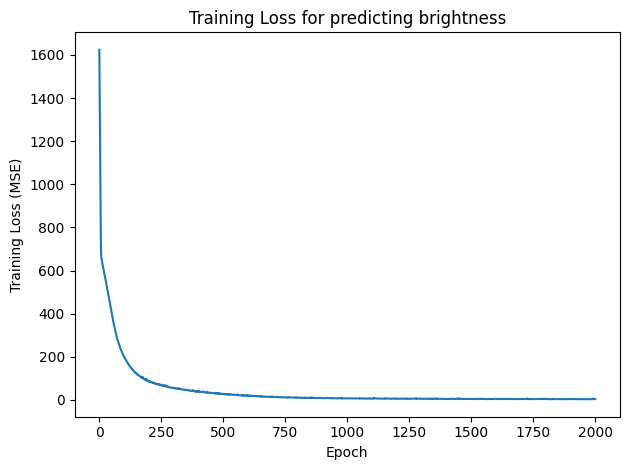

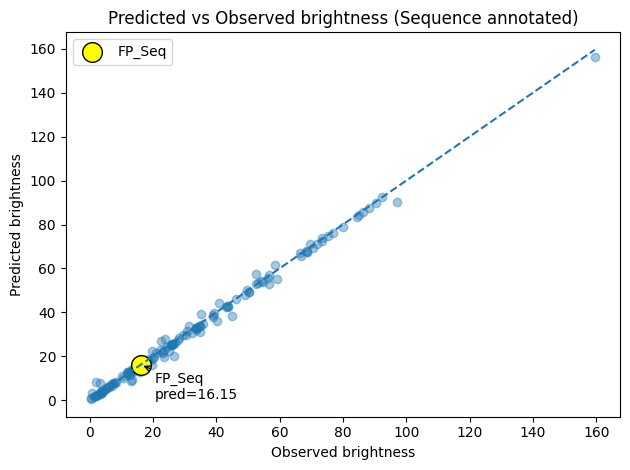

Training complete.


In [1]:
"""
Example script demonstrating how to retrieve fluorescent protein data from the
FPbase REST API and train a simple neural network using PyTorch to predict
various spectral or photophysical properties from the amino-acid sequence.
"""

import os
import requests
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm.auto import trange
from torch.utils.data import TensorDataset, DataLoader

#@markdown ---
#@markdown ## Property selection
#@markdown **Accepted values for `PROPERTY_NAME`:**
#@markdown
#@markdown - **Spectral**
#@markdown   - `ex_max` — excitation maximum *(nm)*
#@markdown   - `em_max` — emission maximum *(nm)*
#@markdown   - `stokes_shift` — excitation/emission separation *(nm)*
#@markdown - **Photophysics**
#@markdown   - `brightness` — FPbase brightness
#@markdown   - `pka` — chromophore pKa
#@markdown ---

PROPERTY_NAME = "brightness"  #@param {type:"string"}


Fluorescent_Protein_Seq = "MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTFSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK"  #@param {type:"string"}

#@markdown ---
#@markdown **Frequently used Taxonomy IDs**
#@markdown - `6100`  *(Aequoria victoria)*
#@markdown - `86600` *(Discosoma sp)*
#@markdown - `6118`  *(Entacmaea quadricolor)*
#@markdown
#@markdown - **Leave Blank to Train on Full FPbase.org Sequence Data**
#@markdown ---
PARENT_ORGANISM = 6100  #@param {type:"integer"}

#@markdown ---

#@markdown **Epochs** *(recommended: 5000 for Spectral Properties)*
#@markdown ---
EPOCHS = 2000  #@param {type:"integer"}

#@markdown **Mini-batch size** *(recommended: 16–64; 0 = full batch)*
BATCH_SIZE = 32  #@param {type:"integer"}


LR = 1e-3

#@markdown ---

EXCLUDE_TERMS = ("channelrhodopsin", "rcamp", "gcamp2", "cp-mkate", "cegfp")
AMINO_ALPHABET = "ACDEFGHIKLMNPQRSTVWY"

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


# -----------------------------------------------------------------------------
# FPbase retrieval + preprocessing
def fetch_fpbase_proteins(parent_organism) -> list:
    """Retrieve proteins for a given parent organism (taxid) from the FPbase API.
    If parent_organism is None or blank, returns the full dataset.
    """
    proteins: list = []
    parent_organism = "" if parent_organism is None else str(parent_organism).strip()
    if parent_organism.lower() in ("", "none", "null"):
        parent_organism = ""

    if parent_organism:
        if not parent_organism.isdigit():
            raise ValueError(f"PARENT_ORGANISM must be numeric or blank. Got: {parent_organism!r}")
        url = f"https://www.fpbase.org/api/proteins/?parent_organism={parent_organism}&format=json"
    else:
        print("TRAINING ON FULL FPBASE.ORG SEQUENCE DATA")
        url = "https://www.fpbase.org/api/proteins/?&format=json"

    while url:
        print(f"Fetching {url} …")
        resp = requests.get(url, timeout=60)
        resp.raise_for_status()
        data = resp.json()

        # FPbase sometimes returns a list; sometimes paginated dict with "results"
        if isinstance(data, list):
            proteins.extend(data)
            break

        results = data.get("results", [])
        proteins.extend(results)
        url = data.get("next")

    return proteins


def compute_stokes_shift(protein: dict) -> float | None:
    """Compute Stokes shift (em_max - ex_max) for the first state with both values."""
    for state in protein.get("states", []) or []:
        ex = state.get("ex_max")
        em = state.get("em_max")
        if ex is not None and em is not None:
            try:
                return float(em) - float(ex)
            except Exception:
                return None
    return None


def extract_property(protein: dict, property_name: str) -> float | None:
    """Extract a scalar property from a protein record."""
    if property_name == "stokes_shift":
        return compute_stokes_shift(protein)
    states = protein.get("states", [])
    if states and isinstance(states, list):
        return states[0].get(property_name)
    return None


def one_hot_encode_sequence(seq: str, max_len: int, alphabet: str = AMINO_ALPHABET) -> np.ndarray:
    """One-hot encode an amino acid sequence up to max_len. Extra positions remain zeros."""
    aa_to_idx = {aa: i for i, aa in enumerate(alphabet)}
    encoding = np.zeros((max_len, len(alphabet)), dtype=np.float32)
    for i, aa in enumerate(seq[:max_len]):
        idx = aa_to_idx.get(aa)
        if idx is not None:
            encoding[i, idx] = 1.0
    return encoding


# -----------------------------------------------------------------------------
# Model
class PropertyPredictor(nn.Module):
    """A simple feed-forward regressor from one-hot sequences to a scalar property."""
    def __init__(self, input_len: int, alphabet_size: int, hidden_dim: int = 64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_len * alphabet_size, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)


# -----------------------------------------------------------------------------
# Model bundle save/load (for reuse in later cells)
def save_model_bundle(path: str, model: nn.Module, *, max_len: int, amino_alphabet: str,
                      property_name: str, parent_organism, hidden_dim: int = 64) -> None:
    os.makedirs(os.path.dirname(path), exist_ok=True)
    bundle = {
        "state_dict": model.state_dict(),
        "max_len": int(max_len),
        "amino_alphabet": str(amino_alphabet),
        "property_name": str(property_name),
        "parent_organism": parent_organism,
        "hidden_dim": int(hidden_dim),
    }
    torch.save(bundle, path)
    # print(f"Saved model bundle to: {path}")


# -----------------------------------------------------------------------------
# Run: fetch -> train -> save -> plots
print(f"Predicting property: {PROPERTY_NAME}")
print(f"Device: {DEVICE}")

# Where bundle will go (depends on property + parent organism)
MODEL_DIR = "models"
MODEL_PATH = os.path.join(
    MODEL_DIR,
    f"fp_{PROPERTY_NAME}_parent{PARENT_ORGANISM if (PARENT_ORGANISM not in [None, '']) else 'ALL'}.pt"
)
# print(f"Bundle path: {MODEL_PATH}")

proteins = fetch_fpbase_proteins(parent_organism=PARENT_ORGANISM)
proteins = [
    p for p in proteins
    if not any(term in (p.get("name") or "").lower() for term in EXCLUDE_TERMS)
]

samples: list[tuple[str, float]] = []
for protein in proteins:
    seq = protein.get("seq")
    value = extract_property(protein, PROPERTY_NAME)
    if seq and value is not None:
        try:
            samples.append((seq, float(value)))
        except Exception:
            pass

if not samples:
    raise RuntimeError(f"No valid samples retrieved for property '{PROPERTY_NAME}'.")

max_len = max(len(seq) for seq, _ in samples)
print(f"Usable samples: {len(samples)}")
print(f"Max sequence length in dataset: {max_len}")

X = np.stack([one_hot_encode_sequence(seq, max_len, AMINO_ALPHABET) for seq, _ in samples])
y = np.array([val for _, val in samples], dtype=np.float32)

X_tensor = torch.tensor(X, dtype=torch.float32).to(DEVICE)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1).to(DEVICE)

HIDDEN_DIM = 64
model = PropertyPredictor(input_len=max_len, alphabet_size=len(AMINO_ALPHABET), hidden_dim=HIDDEN_DIM).to(DEVICE)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=float(LR))

use_minibatch = (BATCH_SIZE is not None) and (int(BATCH_SIZE) > 0)
if use_minibatch:
    bs = int(BATCH_SIZE)
    dataset = TensorDataset(X_tensor, y_tensor)
    loader = DataLoader(dataset, batch_size=bs, shuffle=True, drop_last=False)
    print(f"Using minibatches: batch_size={bs} | steps/epoch={len(loader)}")
else:
    loader = None
    print("Using full-batch training.")

loss_history = []
pbar = trange(int(EPOCHS), desc="Training", unit="epoch", leave=True, colour = 'cyan',bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt} [ETA {remaining}] {postfix}",
)

for epoch in pbar:
    model.train()

    if use_minibatch:
        running_loss = 0.0
        n_samples = 0

        for xb, yb in loader:
            optimizer.zero_grad(set_to_none=True)
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()

            bsz = xb.size(0)
            running_loss += loss.item() * bsz
            n_samples += bsz

        epoch_loss = running_loss / max(1, n_samples)
        loss_history.append(epoch_loss)
        pbar.set_postfix(loss=f"{epoch_loss:.4f}")

    else:
        optimizer.zero_grad(set_to_none=True)
        preds = model(X_tensor)
        loss = criterion(preds, y_tensor)
        loss.backward()
        optimizer.step()
        loss_history.append(loss.item())
        pbar.set_postfix(loss=f"{loss.item():.4f}")

# Save bundle for later reuse
save_model_bundle(
    MODEL_PATH,
    model,
    max_len=max_len,
    amino_alphabet=AMINO_ALPHABET,
    property_name=PROPERTY_NAME,
    parent_organism=PARENT_ORGANISM,
    hidden_dim=HIDDEN_DIM,
)

# In-sample predictions
model.eval()
with torch.no_grad():
    predictions = model(X_tensor).squeeze().detach().cpu().numpy()

# Predict user-provided FP sequence (annotation)
fp_enc = one_hot_encode_sequence(Fluorescent_Protein_Seq, max_len, AMINO_ALPHABET)
fp_tensor = torch.tensor(fp_enc, dtype=torch.float32).unsqueeze(0).to(DEVICE)
with torch.no_grad():
    fp_pred = float(model(fp_tensor).squeeze().item())
print(f"FP_Seq predicted {PROPERTY_NAME}: {fp_pred:.3f}")

# Plot training loss
plt.figure()
plt.plot(range(1, int(EPOCHS) + 1), loss_history)
plt.xlabel("Epoch")
plt.ylabel("Training Loss (MSE)")
plt.title(f"Training Loss for predicting {PROPERTY_NAME}")
plt.tight_layout()
plt.show()

# Plot predicted vs observed (in-sample)
plt.figure()
plt.scatter(y, predictions, alpha=0.4)
min_val = float(min(y.min(), predictions.min(), fp_pred))
max_val = float(max(y.max(), predictions.max(), fp_pred))
plt.plot([min_val, max_val], [min_val, max_val], linestyle="--")

# Place FP_Seq on diagonal for visibility
plt.scatter([fp_pred], [fp_pred], s=200, marker="o", edgecolors="k", label="FP_Seq", color="yellow")
plt.annotate(
    f"FP_Seq\npred={fp_pred:.2f}",
    xy=(fp_pred, fp_pred),
    xytext=(10, -25),
    textcoords="offset points",
    arrowprops=dict(arrowstyle="->"),
)

plt.xlabel(f"Observed {PROPERTY_NAME}")
plt.ylabel(f"Predicted {PROPERTY_NAME}")
plt.title(f"Predicted vs Observed {PROPERTY_NAME} (Sequence annotated)")
plt.legend()
plt.tight_layout()
plt.show()

# Expose trained objects for the next cell (optional convenience)
TRAINED_MODEL = model
TRAINED_MAX_LEN = max_len
TRAINED_ALPHABET = AMINO_ALPHABET
TRAINED_PROPERTY = PROPERTY_NAME
TRAINED_MODEL_PATH = MODEL_PATH

print("Training complete.")
# print(f"Bundle path: {MODEL_PATH}")


<img src="https://raw.githubusercontent.com/CameronLarsonFLT/PyTorch_FP_Prediction/main/FP_Alternate.png" width="650" align="right">


##PyTorch Global Amino Acid Search

**Determines Impact of Mutations on Defined Property**

**Properties:** `ex_max`, `em_max`, `brightness`, `pKa`, `stokes_shift`

Using in-memory trained model.

Template predicted brightness: 16.150034

M1A: predicted brightness = 5.650824   Δ=-10.499210
M1C: predicted brightness = 15.095534   Δ=-1.054500
M1D: predicted brightness = 14.826570   Δ=-1.323464
M1E: predicted brightness = 15.103862   Δ=-1.046172
M1F: predicted brightness = 15.127073   Δ=-1.022961
M1G: predicted brightness = 15.140355   Δ=-1.009679
M1H: predicted brightness = 15.097978   Δ=-1.052056
M1I: predicted brightness = 15.124260   Δ=-1.025774
M1K: predicted brightness = 15.148281   Δ=-1.001753
M1L: predicted brightness = 15.123238   Δ=-1.026796
M1N: predicted brightness = 15.158378   Δ=-0.991656
M1P: predicted brightness = 15.110534   Δ=-1.039500
M1Q: predicted brightness = 15.113601   Δ=-1.036433
M1R: predicted brightness = 15.124335   Δ=-1.025699
M1S: predicted brightness = 15.130023   Δ=-1.020011
M1T: predicted brightness = 15.084636   Δ=-1.065398
M1V: predicted brightness = 9.174411   Δ=-6.975623
M1W: predicted brightness = 15.111339   Δ=-

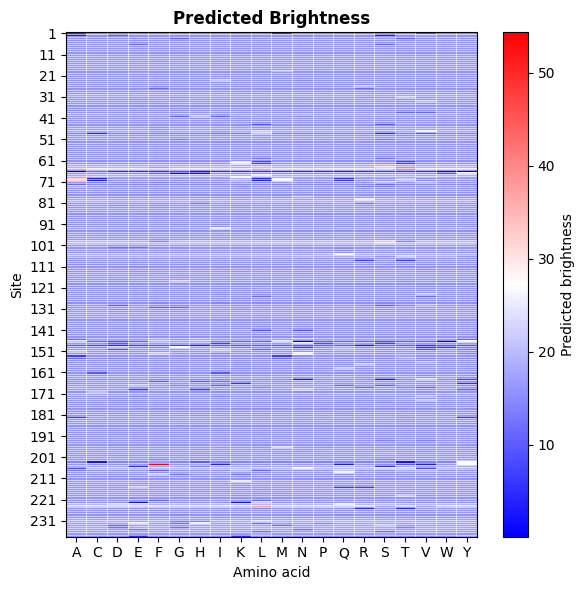

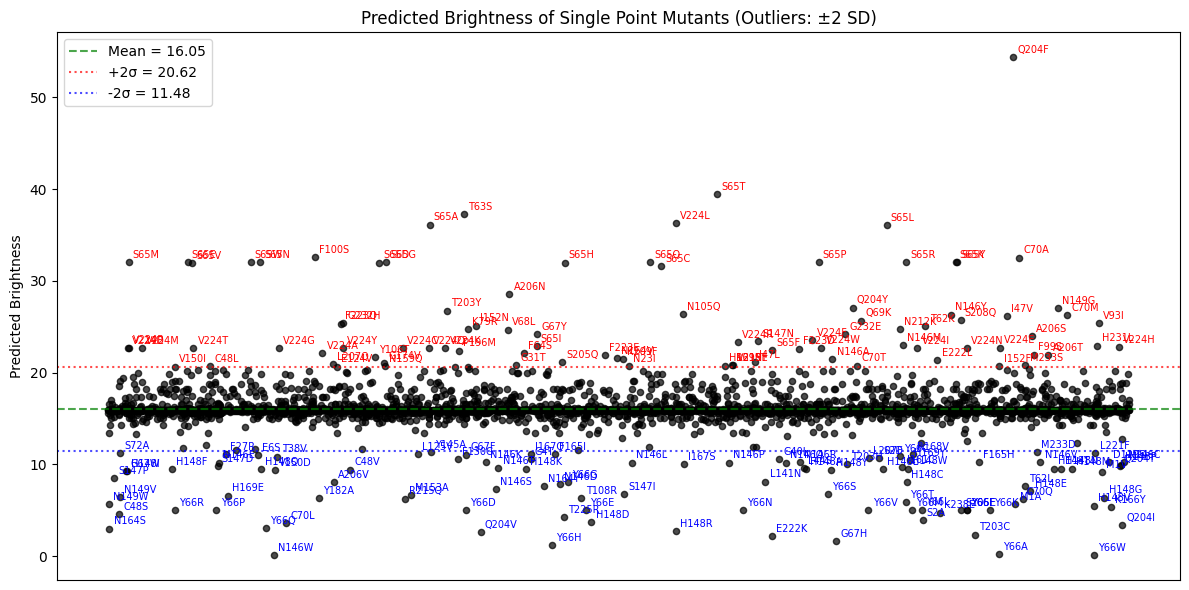

In [2]:
"""
Greedy single-site mutation scan WITHOUT retraining:
- prints ALL mutations with predicted value and delta vs baseline
- builds heatmap (AA on X, site on Y) with white gridlines
- builds jitter scatter of all mutant predictions with ±Nσ outliers annotated

This cell is standalone (does not depend on variables from your reference script).
It will use the in-memory trained model if available; otherwise it loads from a saved bundle.
"""

#@markdown ---
#@markdown #Run Global Amino Acid Search Here
#@markdown ---

import os
import re
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd

# ----------------------------
# User inputs for this cell
# ----------------------------
TEMPLATE_SEQ = (
    "MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTFSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK"
)

# If you trained in a prior cell, TRAINED_MODEL_PATH will exist; otherwise set a path here.
MODEL_PATH = globals().get("TRAINED_MODEL_PATH", "models/fp_stokes_shift_parent6100.pt")

# Use the canonical alphabet unless the bundle contains a different one
DEFAULT_ALPHABET = "ACDEFGHIKLMNPQRSTVWY"

# Outlier annotation parameters for scatter plot
N_STD = 2  # annotate points beyond mean ± N_STD*std
JITTER = 0.20

# Heatmap look (optional)
HEATMAP_FIGSIZE = (6, 6)
HEATMAP_FACE = "w"   # background like your reference
HEATMAP_CMAP = "bwr"       # diverging like reference

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# ----------------------------
# Model + encoding definitions
# ----------------------------
def one_hot_encode_sequence(seq: str, max_len: int, alphabet: str) -> np.ndarray:
    aa_to_idx = {aa: i for i, aa in enumerate(alphabet)}
    arr = np.zeros((max_len, len(alphabet)), dtype=np.float32)
    for i, aa in enumerate(seq[:max_len]):
        idx = aa_to_idx.get(aa)
        if idx is not None:
            arr[i, idx] = 1.0
    return arr

class PropertyPredictor(nn.Module):
    def __init__(self, input_len: int, alphabet_size: int, hidden_dim: int = 64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_len * alphabet_size, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
        )
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)

def load_model_bundle(path: str, device: str = "cpu"):
    bundle = torch.load(path, map_location=device)
    max_len = int(bundle["max_len"])
    alphabet = str(bundle.get("amino_alphabet", DEFAULT_ALPHABET))
    property_name = str(bundle.get("property_name", "property"))
    hidden_dim = int(bundle.get("hidden_dim", 64))

    model = PropertyPredictor(input_len=max_len, alphabet_size=len(alphabet), hidden_dim=hidden_dim).to(device)
    model.load_state_dict(bundle["state_dict"])
    model.eval()
    return model, max_len, alphabet, property_name

# ----------------------------
# Acquire model WITHOUT training
# ----------------------------
if "TRAINED_MODEL" in globals() and "TRAINED_MAX_LEN" in globals() and "TRAINED_ALPHABET" in globals():
    model = globals()["TRAINED_MODEL"].to(DEVICE)
    max_len = int(globals()["TRAINED_MAX_LEN"])
    alphabet = str(globals()["TRAINED_ALPHABET"])
    property_name = str(globals().get("TRAINED_PROPERTY", "property"))
    model.eval()
    print("Using in-memory trained model.")
else:
    if not os.path.exists(MODEL_PATH):
        raise FileNotFoundError(
            f"MODEL_PATH not found: {MODEL_PATH}\n"
            "Run your training cell first (to create the bundle), or set MODEL_PATH to an existing .pt bundle."
        )
    model, max_len, alphabet, property_name = load_model_bundle(MODEL_PATH, device=DEVICE)
    print(f"Loaded model bundle from: {MODEL_PATH}")

# ----------------------------
# Baseline prediction
# ----------------------------
template_enc = one_hot_encode_sequence(TEMPLATE_SEQ, max_len, alphabet)
template_tensor = torch.tensor(template_enc, dtype=torch.float32).unsqueeze(0).to(DEVICE)
with torch.no_grad():
    baseline_pred = float(model(template_tensor).squeeze().item())

print(f"\nTemplate predicted {property_name}: {baseline_pred:.6f}\n")

# ----------------------------
# Greedy single-site scan (PRINT ALL MUTATIONS)
# ----------------------------
mutant_predictions = {}  # label -> predicted
mutant_deltas = {}       # label -> pred - baseline

n_pos = len(TEMPLATE_SEQ)

for pos0, orig_aa in enumerate(TEMPLATE_SEQ):
    site = pos0 + 1
    for new_aa in alphabet:
        if new_aa == orig_aa:
            continue
        mutated_seq = TEMPLATE_SEQ[:pos0] + new_aa + TEMPLATE_SEQ[pos0+1:]

        enc = one_hot_encode_sequence(mutated_seq, max_len, alphabet)
        x = torch.tensor(enc, dtype=torch.float32).unsqueeze(0).to(DEVICE)

        with torch.no_grad():
            pred = float(model(x).squeeze().item())

        label = f"{orig_aa}{site}{new_aa}"
        delta = pred - baseline_pred

        mutant_predictions[label] = pred
        mutant_deltas[label] = delta

        # Print all mutations (as requested)
        print(f"{label}: predicted {property_name} = {pred:.6f}   Δ={delta:+.6f}")

print(f"\nTotal mutants evaluated: {len(mutant_predictions)}")

# ----------------------------
# Build a DataFrame matrix for heatmap
# rows = sites, cols = amino acids (new residue)
# values = predicted property (not delta) for that substitution
# ----------------------------
pattern = re.compile(r"^([A-Z])(\d+)([A-Z])$")
records = []
site_set = set()

for k, v in mutant_predictions.items():
    m = pattern.match(k)
    if not m:
        continue
    _, pos_s, newaa = m.groups()
    pos = int(pos_s)
    records.append((pos, newaa, float(v)))
    site_set.add(pos)

aa_order = list(alphabet)
site_order = sorted(site_set)

df = pd.DataFrame(index=site_order, columns=aa_order, dtype=float)
for pos, newaa, val in records:
    if (pos in df.index) and (newaa in df.columns):
        df.loc[pos, newaa] = val

# Fill NaNs (should only be identity AAs which we skipped) with per-row min for display
filled = df.copy()
if filled.isna().any().any():
    row_mins = filled.min(axis=1)
    for r in filled.index:
        filled.loc[r] = filled.loc[r].fillna(row_mins[r])

# ----------------------------
# HEATMAP FIGURE (like your reference)
# ----------------------------
plt.figure(figsize=HEATMAP_FIGSIZE, facecolor=HEATMAP_FACE)
ax = plt.gca()
ax.set_facecolor(HEATMAP_FACE)

# IMPORTANT: origin="upper" puts site 1 at the top
im = ax.imshow(
    filled.values,
    aspect="auto",
    cmap=HEATMAP_CMAP,
    interpolation="nearest",
    origin="upper"
)

# X ticks: amino acids
ax.set_xticks(np.arange(len(aa_order)))
ax.set_xticklabels(aa_order)

# Y ticks every 10 residues (matching your reference)
ytick_step = 10
ytick_idx = np.arange(0, len(site_order), ytick_step)
ax.set_yticks(ytick_idx)
ax.set_yticklabels([site_order[i] for i in ytick_idx])

# White gridlines around every cell
ax.set_xticks(np.arange(-0.5, len(aa_order), 1), minor=True)
ax.set_yticks(np.arange(-0.5, len(site_order), 1), minor=True)
ax.grid(which="minor", color="white", linestyle="-", linewidth=0.4)
ax.tick_params(which="minor", bottom=False, left=False)

# Labels and title
ax.set_xlabel("Amino acid")
ax.set_ylabel("Site")
ax.set_title(f"Predicted {property_name.title()}", fontweight="bold")

# Colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label(f"Predicted {property_name}")

plt.tight_layout()
plt.show()

# ----------------------------
# JITTER SCATTER FIGURE (outliers annotated) + delta available in export
# ----------------------------
sorted_items = sorted(mutant_predictions.items(), key=lambda x: x[1], reverse=True)
mut_labels = [k for k, _ in sorted_items]
pred_vals = np.array([v for _, v in sorted_items], dtype=float)
delta_vals = np.array([mutant_deltas[k] for k in mut_labels], dtype=float)

mean_val = float(pred_vals.mean())
std_val = float(pred_vals.std(ddof=0))
upper = mean_val + N_STD * std_val
lower = mean_val - N_STD * std_val

x_jitter = np.random.uniform(-JITTER, JITTER, size=len(pred_vals))
x_positions = x_jitter  # centered at 0

plt.figure(figsize=(12, 6), facecolor="w")
ax = plt.gca()
ax.set_facecolor("w")

plt.scatter(x_positions, pred_vals, s=20, alpha=0.7, color = 'k')

# Annotate outliers beyond ±Nσ
for xi, yi, label in zip(x_positions, pred_vals, mut_labels):
    if yi > upper or yi < lower:
        plt.annotate(
            label,
            (xi, yi),
            textcoords="offset points",
            xytext=(3, 3),
            ha="left",
            fontsize=7,
            color="red" if yi > upper else "blue",
        )

plt.axhline(mean_val, linestyle="--", alpha=0.7, label=f"Mean = {mean_val:.2f}", color = 'green')
plt.axhline(upper, linestyle=":", alpha=0.7, label=f"+{N_STD}σ = {upper:.2f}", color = 'red')
plt.axhline(lower, linestyle=":", alpha=0.7, label=f"-{N_STD}σ = {lower:.2f}", color = 'blue')
plt.legend()

plt.ylabel(f"Predicted {property_name.title()}")
plt.title(f"Predicted {property_name.title()} of Single Point Mutants (Outliers: ±{N_STD} SD)")
plt.grid(False)
plt.xticks([])  # hide meaningless x-axis
plt.tight_layout()
plt.show()

# ----------------------------
# Optional: export ALL mutations with prediction + delta
# ----------------------------
out_df = pd.DataFrame({
    "mutation": mut_labels,
    "predicted": pred_vals,
    "delta_vs_template": delta_vals,
}).sort_values("predicted", ascending=False)

csv_name = f"all_single_mutants_{property_name}.csv"
# out_df.to_csv(csv_name, index=False)
# print(f"\nWrote full table (all mutations) to: {csv_name}")


<hr>

<h1 align="right" style="font-size:48px;">PyTorch-Based Design</h1>

<p align="left">
  <img src="https://raw.githubusercontent.com/CameronLarsonFLT/PyTorch_FP_Prediction/main/FP_Design.png" width="550">
</p>

<p align="right">
<ul>
  <li>PyTorch regressor predicts protein properties directly from amino-acid sequence</li>
  <li>Greedy / Top-K search explores single-site mutations from a template</li>
  <li>Mutations ranked by predicted improvement and applied iteratively</li>
  <li>Supports deterministic or stochastic optimization paths</li>
  <li>Outputs optimized variants as FASTA for downstream analysis</li>
</ul>
</p>

<hr>


In [3]:
"""
Greedy search to design N sequences WITHOUT retraining.

Uses ONLY vars already defined in your training cell:
- PROPERTY_NAME, AMINO_ALPHABET, DEVICE
- TRAINED_MODEL / TRAINED_MAX_LEN / TRAINED_ALPHABET / TRAINED_PROPERTY / TRAINED_MODEL_PATH
- Fluorescent_Protein_Seq (template)

Writes ONE multi-FASTA file to OUT_DIR (template first, then designs).

This version is TOP-K ONLY (always samples from top-K at each step).
"""

#@markdown ---
#@markdown # Run Greedy Amino Acid Search with Top-K Sampling
#@markdown ---

import os
import numpy as np
import torch
import torch.nn as nn
import datetime

#@markdown ---
#@markdown ## Objective
#@markdown - MAXIMIZE=True for properties like brightness, stokes_shift, em_max
#@markdown - MAXIMIZE=False for properties you want to minimize
#@markdown ---
MAXIMIZE = True  #@param {type:"boolean"}

#@markdown ---
#@markdown ## Greedy step threshold (in *nm, pKa, or brightness units*)
#@markdown A mutation is only accepted if it improves the current prediction by at least this amount.
#@markdown ---
STEP_THRESHOLD = 4.0  #@param {type:"number"}

#@markdown ---
#@markdown ## Design controls
#@markdown - N_DESIGNS = how many designed sequences to generate
#@markdown - MAX_MUTATIONS = max mutations per design
#@markdown ---
N_DESIGNS = 10      #@param {type:"integer"}
MAX_MUTATIONS = 10   #@param {type:"integer"}

#@markdown ---
#@markdown ## Top-K sampling (ALWAYS ON)
#@markdown At each step, we:
#@markdown 1) score all single-AA mutations that pass threshold
#@markdown 2) sort by predicted property
#@markdown 3) randomly pick ONE from the top-K
#@markdown ---
TOPK_PER_STEP = 10  #@param {type:"integer"}

#@markdown ---
#@markdown ## Optional constraint
#@markdown If True, don't mutate the same position twice within a design.
#@markdown ---
AVOID_REPEAT_POS = False  #@param {type:"boolean"}

#@markdown ---
#@markdown ## Output
#@markdown ---
OUT_DIR = "designed_seqs_greedy"     #@param {type:"string"}
WRITE_FASTA = True                  #@param {type:"boolean"}
MULTIFASTA_BASENAME = "ALL_DESIGNS"  #@param {type:"string"}

# ----------------------------
# Model helpers (must match training architecture)
# ----------------------------
def one_hot_encode_sequence(seq: str, max_len: int, alphabet: str) -> np.ndarray:
    aa_to_idx = {aa: i for i, aa in enumerate(alphabet)}
    arr = np.zeros((max_len, len(alphabet)), dtype=np.float32)
    for i, aa in enumerate(seq[:max_len]):
        idx = aa_to_idx.get(aa)
        if idx is not None:
            arr[i, idx] = 1.0
    return arr

class PropertyPredictor(nn.Module):
    def __init__(self, input_len: int, alphabet_size: int, hidden_dim: int = 64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_len * alphabet_size, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
        )
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)

def load_model_bundle(path: str, device: str = "cpu"):
    bundle = torch.load(path, map_location=device)
    max_len = int(bundle["max_len"])
    alphabet = str(bundle.get("amino_alphabet", AMINO_ALPHABET))
    prop = str(bundle.get("property_name", PROPERTY_NAME))
    hidden_dim = int(bundle.get("hidden_dim", 64))

    model = PropertyPredictor(input_len=max_len, alphabet_size=len(alphabet), hidden_dim=hidden_dim).to(device)
    model.load_state_dict(bundle["state_dict"])
    model.eval()
    return model, max_len, alphabet, prop

def predict_seq(model: nn.Module, seq: str, max_len: int, alphabet: str, device: str) -> float:
    enc = one_hot_encode_sequence(seq, max_len, alphabet)
    x = torch.tensor(enc, dtype=torch.float32).unsqueeze(0).to(device)
    with torch.no_grad():
        return float(model(x).squeeze().item())

def muts_to_labels(original_seq: str, mutated_seq: str) -> list[str]:
    labels = []
    for i, (a, b) in enumerate(zip(original_seq, mutated_seq)):
        if a != b:
            labels.append(f"{a}{i+1}{b}")
    return labels

def wrap_fasta(seq: str, width: int = 60) -> str:
    return "\n".join(seq[i:i+width] for i in range(0, len(seq), width))

# ----------------------------
# Acquire trained model (NO retraining)
# ----------------------------
if "TRAINED_MODEL" in globals() and "TRAINED_MAX_LEN" in globals() and "TRAINED_ALPHABET" in globals():
    model = TRAINED_MODEL.to(DEVICE)
    max_len = int(TRAINED_MAX_LEN)
    trained_alphabet = str(TRAINED_ALPHABET)
    trained_prop = str(globals().get("TRAINED_PROPERTY", PROPERTY_NAME))
    model.eval()
    print("Using in-memory trained model.")
else:
    if not ("TRAINED_MODEL_PATH" in globals()):
        raise RuntimeError("TRAINED_MODEL_PATH not found. Run the training cell first.")
    if not os.path.exists(TRAINED_MODEL_PATH):
        raise FileNotFoundError(f"Model bundle not found: {TRAINED_MODEL_PATH}")
    model, max_len, trained_alphabet, trained_prop = load_model_bundle(TRAINED_MODEL_PATH, device=DEVICE)
    print(f"Loaded model bundle from: {TRAINED_MODEL_PATH}")

if trained_prop != PROPERTY_NAME:
    print(f"WARNING: bundle property_name={trained_prop} but current PROPERTY_NAME={PROPERTY_NAME}. Using {trained_prop}.")

alphabet = trained_alphabet
template = Fluorescent_Protein_Seq
scan_positions = list(range(len(template)))

print(f"Device: {DEVICE}")
print(f"Property: {trained_prop} | MAXIMIZE={MAXIMIZE}")
print(f"Template length: {len(template)} | max_len: {max_len}")
print(f"Alphabet size used this run: {len(alphabet)}")

if bool(WRITE_FASTA):
    os.makedirs(OUT_DIR, exist_ok=True)

baseline_pred = predict_seq(model, template, max_len, trained_alphabet, DEVICE)
print(f"\nTemplate predicted {trained_prop}: {baseline_pred:.6f}\n")

timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
multifasta_path = None
if bool(WRITE_FASTA):
    multifasta_path = os.path.join(OUT_DIR, f"{MULTIFASTA_BASENAME}_{trained_prop}_{timestamp}.fasta")

# ----------------------------
# Top-K greedy design loop (single design)
# ----------------------------
def topk_design() -> tuple[str, float]:
    current = template
    current_pred = baseline_pred
    used_positions = set()

    for _step in range(1, int(MAX_MUTATIONS) + 1):
        candidates = []  # (new_pred, delta, pos0, newaa)

        for pos0 in scan_positions:
            if bool(AVOID_REPEAT_POS) and (pos0 in used_positions):
                continue
            orig = current[pos0]
            for newaa in alphabet:
                if newaa == orig:
                    continue

                trial = current[:pos0] + newaa + current[pos0+1:]
                trial_pred = predict_seq(model, trial, max_len, trained_alphabet, DEVICE)
                delta = trial_pred - current_pred

                if bool(MAXIMIZE):
                    if delta >= float(STEP_THRESHOLD):
                        candidates.append((trial_pred, delta, pos0, newaa))
                else:
                    if delta <= -float(STEP_THRESHOLD):
                        candidates.append((trial_pred, delta, pos0, newaa))

        if not candidates:
            break

        # Sort by objective
        if bool(MAXIMIZE):
            candidates.sort(key=lambda x: x[0], reverse=True)
        else:
            candidates.sort(key=lambda x: x[0])

        # Sample ONE from top-K
        k = max(1, min(int(TOPK_PER_STEP), len(candidates)))
        chosen = candidates[np.random.randint(0, k)]

        new_pred, _delta, pos0, newaa = chosen
        current = current[:pos0] + newaa + current[pos0+1:]
        current_pred = new_pred
        used_positions.add(pos0)

    return current, current_pred

# ----------------------------
# Generate N designs (duplicates allowed) + write multifasta
# ----------------------------
fh_multi = None
if bool(WRITE_FASTA):
    fh_multi = open(multifasta_path, "w", encoding="utf-8")
    fh_multi.write(f">TEMPLATE_{trained_prop}_pred={baseline_pred:.6f}\n")
    fh_multi.write(wrap_fasta(template) + "\n")

try:
    for i in range(1, int(N_DESIGNS) + 1):
        seq, pred = topk_design()
        labels = muts_to_labels(template, seq)
        delta_vs_template = pred - baseline_pred

        design_name = f"Design_{i:03d}_{trained_prop}"
        header = f">{design_name}_pred={pred:.6f}_delta_vs_template={delta_vs_template:+.6f}_nmut={len(labels)}"

        print(header)
        print(f"Mutations: {', '.join(labels) if labels else '(none)'}")
        print(wrap_fasta(seq))
        print()

        if bool(WRITE_FASTA) and fh_multi is not None:
            fh_multi.write(header + "\n")
            fh_multi.write(wrap_fasta(seq) + "\n")
finally:
    if fh_multi is not None:
        fh_multi.close()

if bool(WRITE_FASTA):
    print(f"\nMulti-FASTA written to:\n  {multifasta_path}")


Using in-memory trained model.
Device: cuda
Property: brightness | MAXIMIZE=True
Template length: 238 | max_len: 353
Alphabet size used this run: 20

Template predicted brightness: 16.150034

>Design_001_brightness_pred=169.306320_delta_vs_template=+153.156286_nmut=10
Mutations: T63S, S65A, Q69K, C70M, N105Q, N146Y, N149G, T203Y, Q204F, A206N
MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTL
VTSFAYGVKMFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGQYKTRAEVKFEGDTLV
NRIELKGIDFKEDGNILGHKLEYNYYSHGVYIMADKQKNGIKVNFKIRHNIEDGSVQLAD
HYQQNTPIGDGPVLLPDNHYLSYFSNLSKDPNEKRDHMVLLEFVTAAGITHGMDELYK

>Design_002_brightness_pred=145.958267_delta_vs_template=+129.808233_nmut=10
Mutations: I47V, T63S, S65T, Q69K, C70A, V93I, N149G, T203Y, S208Q, F223Q
MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFVCTTGKLPVPWPTL
VTSFTYGVKAFSRYPDHMKQHDFFKSAMPEGYIQERTIFFKDDGNYKTRAEVKFEGDTLV
NRIELKGIDFKEDGNILGHKLEYNYNSHGVYIMADKQKNGIKVNFKIRHNIEDGSVQLAD
HYQQNTPIGDGPVLLPDNHYLSYQSALQKDPNEKRDHMVLLEQVTAAGITHGMDELYK

>Design_003_bright

In [4]:
#@markdown ---
#@markdown # Download Dependencies to Generate MSA
#@markdown ---


RUN_INSTALL = True
if RUN_INSTALL:
    print("Downloading dependencies...\n")

    from tqdm.auto import tqdm
    import subprocess

    steps = [
        ["apt-get", "-qq", "update"],
        ["apt-get", "-qq", "install", "-y", "mafft"],
        ["pip", "-q", "install", "pymsaviz"],
        ["pip", "-q", "install", "biopython"],
    ]

    with tqdm(
        total=len(steps),
        desc="",
        bar_format="{bar} {n_fmt}/{total_fmt}",
        colour="cyan",
    ) as pbar:
        for cmd in steps:
            subprocess.run(cmd, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL, check=True)
            pbar.update(1)


           0/4

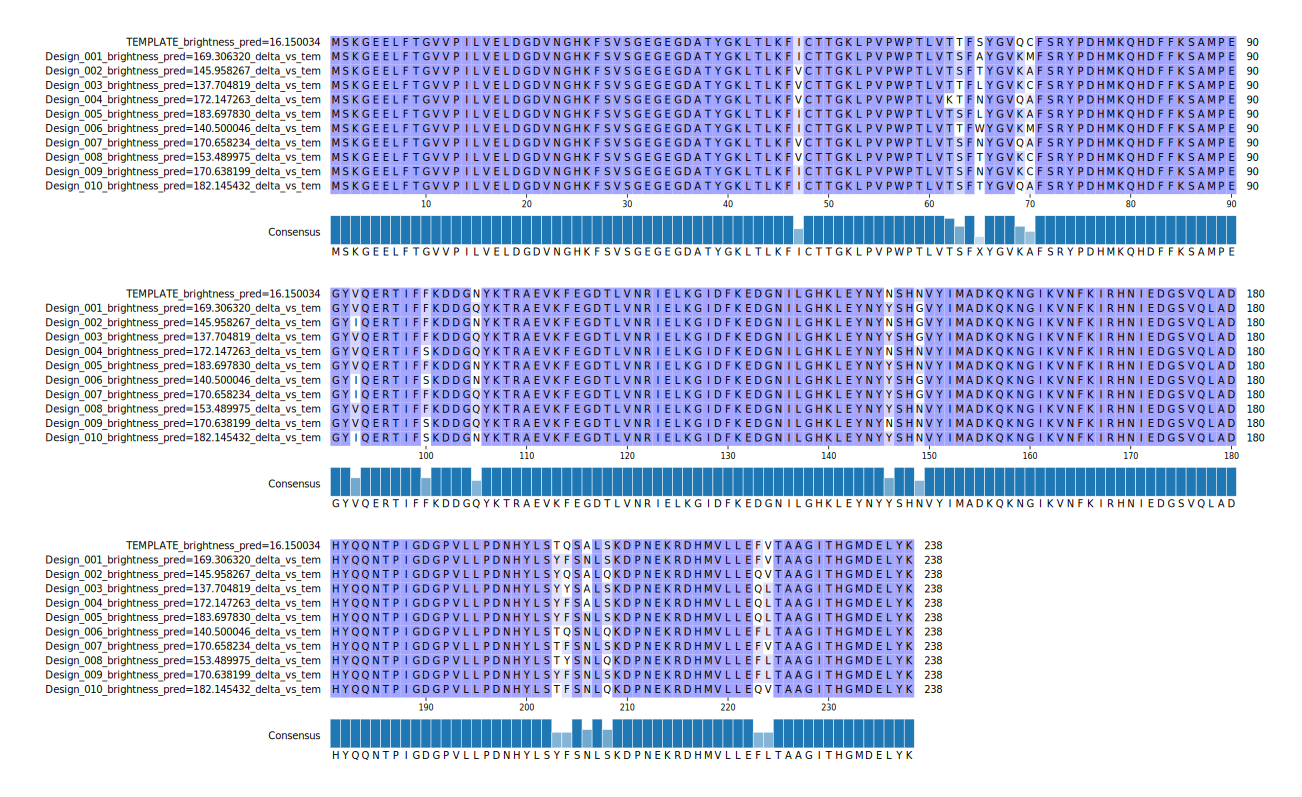

In [5]:
#@markdown ---
#@markdown # Run MAFFT MSA on the multi-FASTA
#@markdown ---

import os
import subprocess
from datetime import datetime
import tempfile
from collections import Counter

from Bio import SeqIO, AlignIO
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq

try:
    from pymsaviz import MsaViz
except ImportError:
    MsaViz = None

from IPython.display import SVG, display


#@markdown ---
#@markdown ## Inputs / Outputs
#@markdown ---
INPUT_FASTA = multifasta_path  #@param {type:"string"}
OUTDIR = "msa_outputs"         #@param {type:"string"}

#@markdown ---
#@markdown ## Visualization
#@markdown ---
WRAP_LENGTH = 90               #@param {type:"integer"}
CONSENSUS_THRESHOLD = 0.501    #@param {type:"number"}
MAKE_SVG = True                #@param {type:"boolean"}

# Always do U->X; do NOT use --anysymbol
REPLACE_U_WITH_X = True
USE_ANY_SYMBOL = False


def consensus_from_alignment(msa, threshold=0.501, gap_char="-"):
    L = msa.get_alignment_length()
    out = []
    for col in range(L):
        syms = [rec.seq[col] for rec in msa]
        non_gaps = [c for c in syms if c != gap_char]
        if not non_gaps:
            out.append(gap_char)
            continue
        counts = Counter(non_gaps)
        top, n = counts.most_common(1)[0]
        out.append(top if (n / len(non_gaps)) >= threshold else "X")
    return "".join(out)


def run_basic_msa(input_fasta_path: str, output_dir: str):
    os.makedirs(output_dir, exist_ok=True)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    with tempfile.TemporaryDirectory() as tmpdir:
        cleaned_fasta = os.path.join(tmpdir, "cleaned.fasta")
        aligned_fasta = os.path.join(tmpdir, "aligned.fasta")

        # Clean FASTA (U->X, strip non-AA)
        cleaned = []
        allowed = set("ACDEFGHIKLMNPQRSTVWYXBZJO-")  # exclude U because we replace it

        for rec in SeqIO.parse(input_fasta_path, "fasta"):
            seq = str(rec.seq).upper()
            if REPLACE_U_WITH_X:
                seq = seq.replace("U", "X")
            seq = "".join(c for c in seq if c in allowed)
            if seq:
                cleaned.append(SeqRecord(Seq(seq), id=rec.id[:50], description=""))

        SeqIO.write(cleaned, cleaned_fasta, "fasta")

        # MAFFT
        mafft = ["mafft", "--auto", cleaned_fasta]
        proc = subprocess.run(mafft, capture_output=True, text=True)
        if proc.returncode != 0:
            raise RuntimeError(proc.stderr or "MAFFT failed (no stderr)")

        with open(aligned_fasta, "w", encoding="utf-8") as f:
            f.write(proc.stdout)

        alignment = AlignIO.read(aligned_fasta, "fasta")
        consensus = consensus_from_alignment(alignment, float(CONSENSUS_THRESHOLD))

        aln_out = os.path.join(output_dir, f"aligned_{timestamp}.fasta")
        con_out = os.path.join(output_dir, f"consensus_{timestamp}.txt")
        AlignIO.write(alignment, aln_out, "fasta")
        with open(con_out, "w", encoding="utf-8") as f:
            f.write(consensus + "\n")

        if MAKE_SVG and MsaViz is not None:
            svg_path = os.path.join(output_dir, f"msa_{timestamp}.svg")
            viz = MsaViz(
                aln_out,
                wrap_length=int(WRAP_LENGTH),
                show_label=True,
                show_count=True,
                show_consensus=True,
                color_scheme="Identity",
            )
            viz.savefig(svg_path)
            display(SVG(filename=svg_path))


# Run
run_basic_msa(INPUT_FASTA, OUTDIR)
